In [ ]:
# Bibliotecas para manipulação e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para modelagem de série temporal e machine learning
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller

# Bibliotecas para Deep Learning com Keras/TensorFlow
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input
from keras.callbacks import EarlyStopping

# Configurações para melhorar a visualização dos dados
import warnings
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
warnings.filterwarnings('ignore')
sns.set_context("paper", font_scale=1.3)
sns.set_style('whitegrid')

✅ Bibliotecas importadas e ambiente configurado.


In [ ]:
print("Carregando e limpando a base de dados...")

caminho_arquivo = 'dados/household_power_consumption.txt'
try:
    data = pd.read_csv(
        caminho_arquivo,
        sep=';',
        low_memory=False,
        na_values=['nan', '?']
    )
    # Combina e converte as colunas de data e hora
    data['date_time'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
    data.drop(['Date', 'Time'], axis=1, inplace=True)
    data.set_index('date_time', inplace=True)

    # Converte todas as colunas para o tipo numérico
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Remove qualquer linha que ainda tenha valores ausentes
    data.dropna(inplace=True)
    print(f"   - Dados carregados com sucesso. Total de registros válidos: {len(data)}")

except Exception as e:
    print(f"Erro ao carregar o arquivo: {e}")
    # Se der erro, cria um dataframe vazio para o restante do notebook não quebrar
    data = pd.DataFrame()

# Exibe as 5 primeiras linhas para ver a estrutura dos dados
print("\n--- Amostra dos Dados Limpos ---")
if not data.empty:
    print(data.head().to_string())

✅ Carregando e limpando a base de dados...
   - Dados carregados com sucesso. Total de registros válidos: 2049280

--- Amostra dos Dados Limpos ---
                     Global_active_power  Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3
date_time                                                                                                                                 
2006-12-16 17:24:00               4.2160                 0.4180 234.8400           18.4000          0.0000          1.0000         17.0000
2006-12-16 17:25:00               5.3600                 0.4360 233.6300           23.0000          0.0000          1.0000         16.0000
2006-12-16 17:26:00               5.3740                 0.4980 233.2900           23.0000          0.0000          2.0000         17.0000
2006-12-16 17:27:00               5.3880                 0.5020 233.7400           23.0000          0.0000          1.0000         17.0000
2006-12-16 17:28:0


📊 Gerando gráfico de médias de consumo (Diária, Semanal, Mensal)...


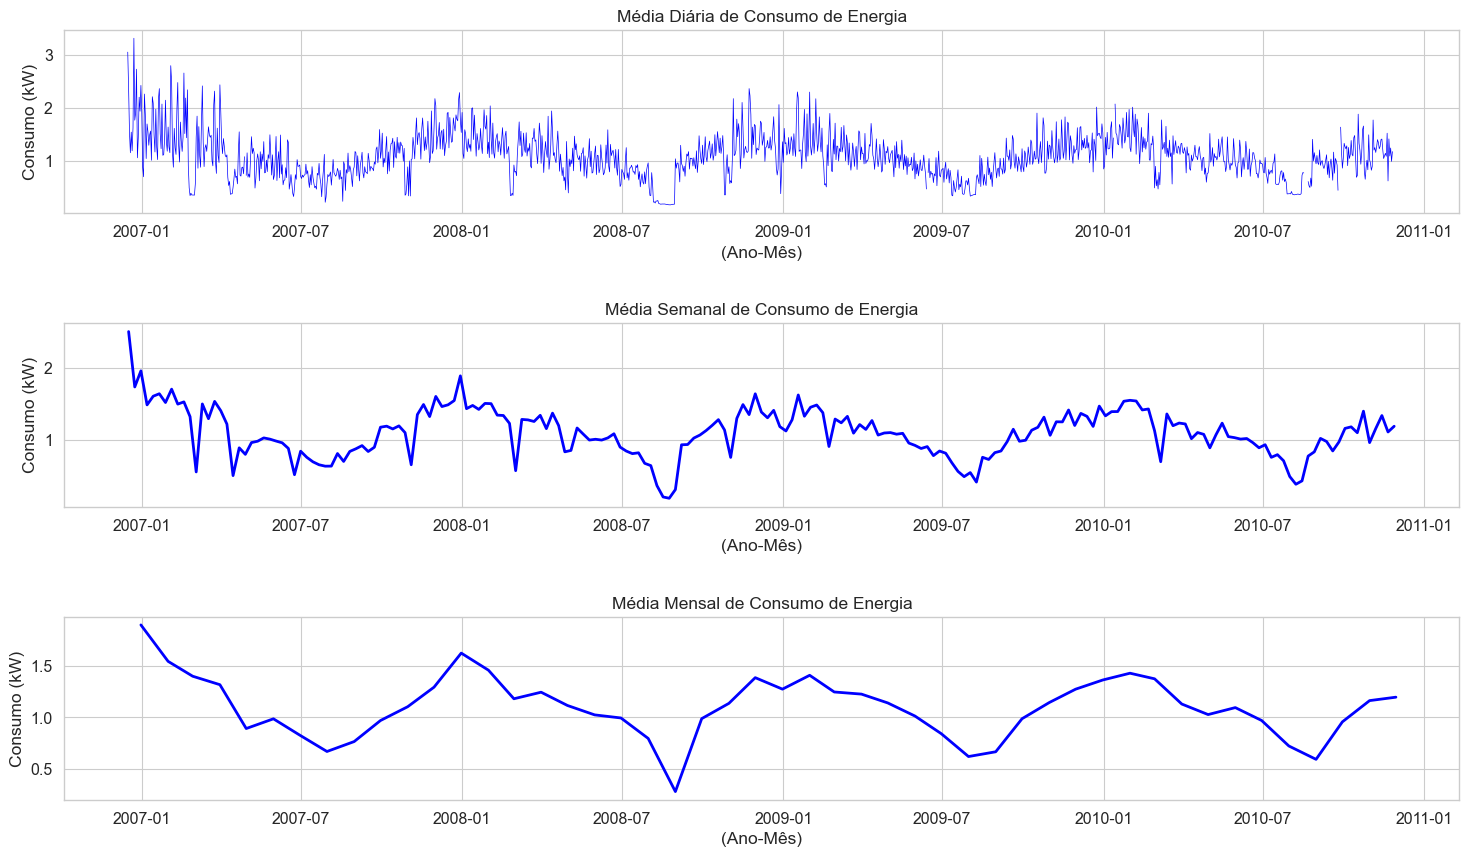

In [ ]:
print("\nGerando gráfico de médias de consumo (Diária, Semanal, Mensal)...")

if not data.empty:
    data_resampled = data['Global_active_power']
    fig = plt.figure(figsize=(18, 10))
    fig.subplots_adjust(hspace=0.6)
    
    # Média Diária
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(data_resampled.resample('D').mean(), linewidth=0.5, color='blue')
    ax1.set_title('Média Diária de Consumo de Energia')
    ax1.set_ylabel('Consumo (kW)')
    ax1.set_xlabel('(Ano-Mês)')

    # Média Semanal
    ax2 = fig.add_subplot(3, 1, 2, sharex=ax1)
    ax2.plot(data_resampled.resample('W').mean(), linewidth=2, color='blue')
    ax2.set_title('Média Semanal de Consumo de Energia')
    ax2.set_ylabel('Consumo (kW)')
    ax2.set_xlabel('(Ano-Mês)')

    # Média Mensal
    ax3 = fig.add_subplot(3, 1, 3, sharex=ax1)
    ax3.plot(data_resampled.resample('M').mean(), linewidth=2, color='blue')
    ax3.set_title('Média Mensal de Consumo de Energia')
    ax3.set_ylabel('Consumo (kW)')
    ax3.set_xlabel('(Ano-Mês)')
    
    plt.show()

In [ ]:
def test_stationarity(timeseries):
    print('\n--- 🕵️ Resultados do Teste Dickey-Fuller (Estacionariedade) ---')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estatística do Teste','p-valor','# de Lags Usados','Nº de Observações'])
    for key, value in dftest[4].items():
        dfoutput[f'Valor Crítico ({key})'] = value
    print(dfoutput)
    if dfoutput['p-valor'] <= 0.05:
        print("\nResultado: A série temporal é ESTACIONÁRIA (p-valor <= 0.05).")
    else:
        print("\nResultado: A série temporal NÃO é estacionária (p-valor > 0.05).")

if not data.empty:
    # Usamos a média diária para o teste, pois o dataset completo é muito grande
    test_stationarity(data['Global_active_power'].resample('D').mean().dropna())


--- 🕵️ Resultados do Teste Dickey-Fuller (Estacionariedade) ---
Estatística do Teste     -3.6842
p-valor                   0.0043
# de Lags Usados         22.0000
Nº de Observações      1410.0000
Valor Crítico (1%)       -3.4350
Valor Crítico (5%)       -2.8636
Valor Crítico (10%)      -2.5679
dtype: float64

Resultado: A série temporal é ESTACIONÁRIA (p-valor <= 0.05).


In [ ]:
print("\nPreparando os dados para o formato da LSTM...")

if not data.empty:
    dataset = data['Global_active_power'].values.astype('float32').reshape(-1, 1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset_scaled = scaler.fit_transform(dataset)

    train_size = int(len(dataset_scaled) * 0.80) # Divisão: 80% do dataset normalizado pra treinamento
    train, test = dataset_scaled[0:train_size, :], dataset_scaled[train_size:len(dataset_scaled), :]
    # Outros 20% restantes para teste

    def create_dataset(dataset, look_back=1):
        X, Y = [], []
        for i in range(len(dataset) - look_back - 1):
            X.append(dataset[i:(i + look_back), 0])
            Y.append(dataset[i + look_back, 0])
        return np.array(X), np.array(Y)

    look_back = 30 # Vê os últimos 30 minutos para prever o próximo minuto
    X_train, Y_train = create_dataset(train, look_back)
    X_test, Y_test = create_dataset(test, look_back)

    # Reformata para o padrão da LSTM: [amostras, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    print(f"   - Dados prontos! Formato dos dados de treino: {X_train.shape}")


✅ Preparando os dados para o formato da LSTM...
   - Dados prontos! Formato dos dados de treino: (1639393, 1, 30)


In [ ]:
print("\nConstruindo e treinando o modelo LSTM...")
if 'X_train' in locals():
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(100),
        Dropout(0.2), # Essa linha faz com que o modelo "desligue" alguns neurônios durante o treinamento. 
        ## Isso é uma técnica de regularização que melhora a generalização
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    print("\n--- Arquitetura do Modelo ---")
    model.summary()

    # O EarlyStopping para o treino se o erro não melhorar, otimizando o tempo
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

    print("\n--- Iniciando Treinamento (esta etapa pode demorar) ---")
    history = model.fit(
        X_train, Y_train,
        epochs=20,
        batch_size=1240,
        validation_data=(X_test, Y_test),
        callbacks=[early_stopping],
        verbose=1,
        shuffle=False
    )
    print("\nTreinamento concluído!")


🚀 Construindo e treinando o modelo LSTM...

--- Arquitetura do Modelo ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        52,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,501 (205.08 KB)

 Trainable params: 52,501 (205.08 KB)

 Non-trainable params: 0 (0.00 B)


--- Iniciando Treinamento (esta etapa pode demorar) ---
Epoch 1/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0024 - val_loss: 4.1003e-04
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 8.4924e-04 - val_loss: 3.9577e-04
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 8.3780e-04 - val_loss: 3.9221e-04
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 8.2665e-04 - val_loss: 3.9003e-04
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 8.1699e-04 - val_loss: 3.8830e-04
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 8.1374e-04 - val_loss: 3.8900e-04
Epoch 7/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 8.0650e-04 - val_loss: 3.9077e-04
Epoch 8/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 8.0241e-04 - val_loss: 3.8899e-04
Epoch 9/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 7.9812e-04 - val_loss: 3.8774e-04
Epoch 10/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 7.9707e-04 - val_los

In [ ]:
print("\nAvaliando o desempenho do modelo...")
if 'model' in locals():
    # Fazendo previsões
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invertendo a normalização para ter os valores em kW
    train_predict = scaler.inverse_transform(train_predict)
    Y_train_inv = scaler.inverse_transform([Y_train])
    test_predict = scaler.inverse_transform(test_predict)
    Y_test_inv = scaler.inverse_transform([Y_test])

    # Calculando o RMSE
    train_rmse = np.sqrt(mean_squared_error(Y_train_inv[0], train_predict[:, 0]))
    test_rmse = np.sqrt(mean_squared_error(Y_test_inv[0], test_predict[:, 0]))

    print("\n--- Tabela de Comparação (Amostra dos Dados de Teste) ---")
    # 15 amostras aleatórias
    indices_aleatorios = np.random.choice(len(Y_test_inv[0]), 15, replace=False)
    tabela_comparacao = pd.DataFrame({
        'Consumo Real (kW)': Y_test_inv[0][indices_aleatorios],
        'Previsão do Modelo (kW)': test_predict[:, 0][indices_aleatorios]
    })
    tabela_comparacao['Diferença (kW)'] = abs(tabela_comparacao['Consumo Real (kW)'] - tabela_comparacao['Previsão do Modelo (kW)'])
    print(tabela_comparacao.to_string())

    print("\n--- RESUMO FINAL DA ANÁLISE ---")
    print(f"O Erro Médio Quadrático (RMSE) no conjunto de TREINO foi de: {train_rmse:.4f} kW")
    print(f"O Erro Médio Quadrático (RMSE) no conjunto de TESTE foi de:  {test_rmse:.4f} kW")
    print(f"\nInterpretação: Em média, o modelo errou suas previsões em {test_rmse:.4f} kW nos dados que nunca tinha visto antes.")


📈 Avaliando o desempenho do modelo...
    1/51232 ━━━━━━━━━━━━━━━━━━━━ 13:06 15ms/step

51232/51232 ━━━━━━━━━━━━━━━━━━━━ 13s 262us/step
12808/12808 ━━━━━━━━━━━━━━━━━━━━ 3s 261us/step

--- 📋 Tabela de Comparação (Amostra dos Dados de Teste) ---
    Consumo Real (kW)  Previsão do Modelo (kW)  Diferença (kW)
0              2.0720                   1.5809          0.4911
1              0.3580                   0.3638          0.0058
2              1.7160                   1.7452          0.0292
3              0.6400                   0.7515          0.1115
4              0.1580                   0.1544          0.0036
5              2.0900                   2.4717          0.3817
6              0.2460                   0.2485          0.0025
7              3.5100                   3.7571          0.2471
8              1.4940                   1.5119          0.0179
9              0.3340                   0.3380          0.0040
10             0.1800                   0.1512          0.0288
11             0.3160                   0.3193          0.0033
12             3.5240    

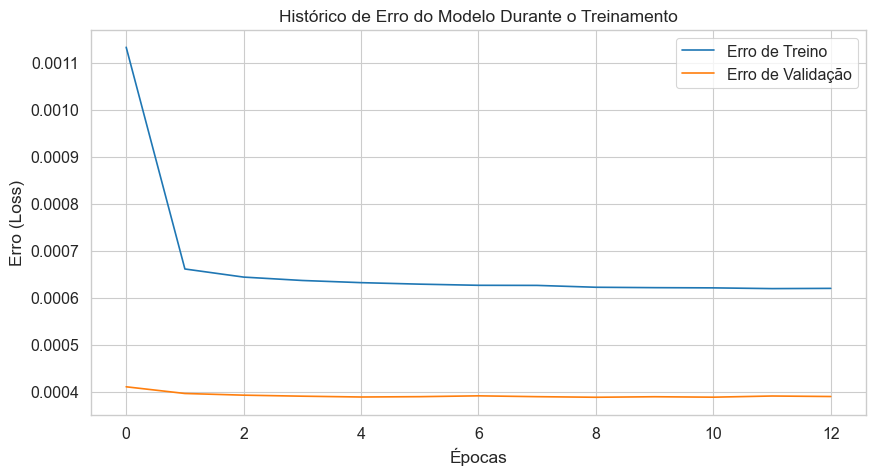

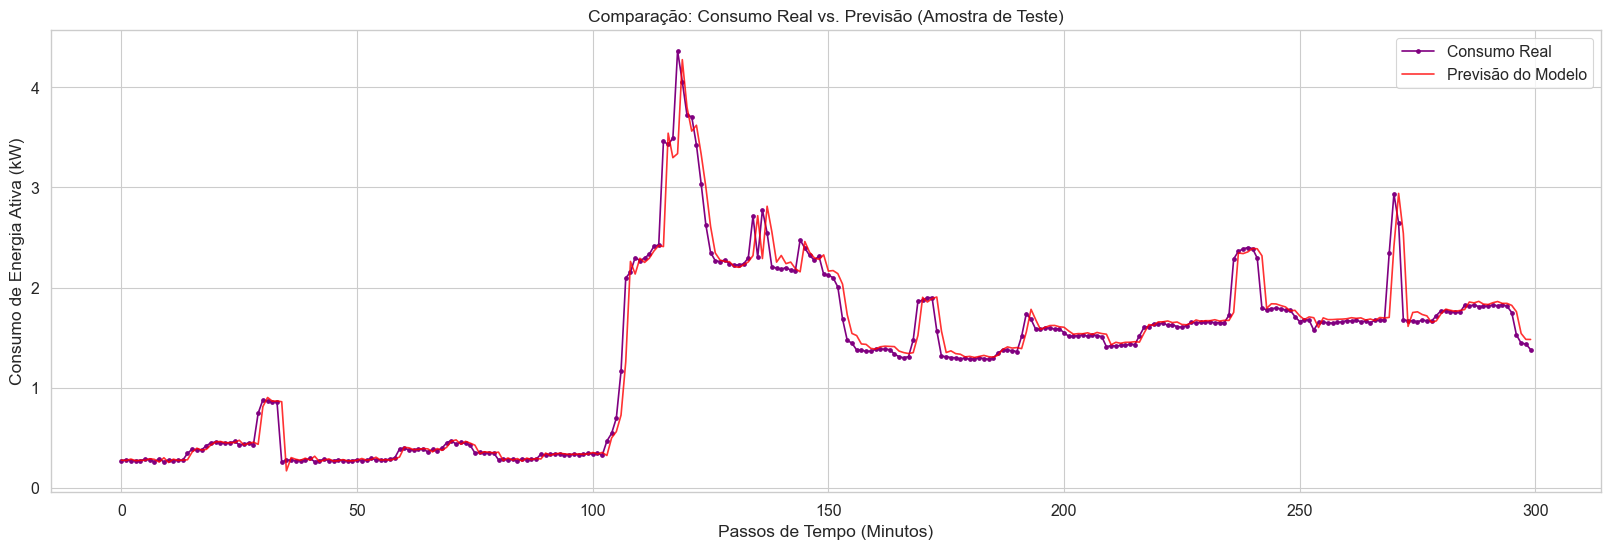


✅ Análise concluída com sucesso!


In [ ]:
if 'history' in locals():
    # Gráfico de Perda (Loss) do Treinamento
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Erro de Treino')
    plt.plot(history.history['val_loss'], label='Erro de Validação')
    plt.title('Histórico de Erro do Modelo Durante o Treinamento')
    plt.ylabel('Erro (Loss)')
    plt.xlabel('Épocas')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Gráfico de Previsão vs. Real
    plt.figure(figsize=(20, 6))
    plot_range = 300 # Vamos plotar 300 pontos para uma boa visualização
    plt.plot(Y_test_inv[0][:plot_range], marker='.', label="Consumo Real", color='purple')
    plt.plot(test_predict[:, 0][:plot_range], '-', label="Previsão do Modelo", color='red', alpha=0.8)
    plt.title('Comparação: Consumo Real vs. Previsão (Amostra de Teste)')
    plt.ylabel('Consumo de Energia Ativa (kW)')
    plt.xlabel('Passos de Tempo (Minutos)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print("\nAnálise concluída com sucesso!")